In [52]:
import os
import torch
import numpy as np
import pandas as pd

In [53]:
ge = np.load("/Users/bram/jointomicscomp/data/GE.npy")
cancerTypes = np.load("/Users/bram/jointomicscomp/data/cancerTypes.npy")
cancerType = np.load("/Users/bram/jointomicscomp/data/cancerType.npy")
cancer_type_labels = cancerTypes[cancerType.astype(int)]

In [72]:
class UMAPPlotter:
    """
    Class that creates UMAP for any provided data matrix.
    """
    def __init__(self, data, labels, title, save_file, n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean', background='white', color_key_cmap='Spectral', dpi=1200):
        self.data = data
        self.labels = labels
        self.title = title
        self.save_file = save_file
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.n_components= n_components
        self.metric = metric
        self.background = background
        self.color_key_cmap = color_key_cmap
        self.dpi = dpi
        
    def show(self):
        import umap.plot
        
        mapper = umap.UMAP(
            n_neighbors=self.n_neighbors,
            min_dist=self.min_dist,
            n_components=self.n_components,
            metric=self.metric
        ).fit(self.data)
        
        p = umap.plot.points(mapper, labels=self.labels, color_key_cmap=self.color_key_cmap, background=self.background)
        umap.plot.plt.title(self.title)
        umap.plot.plt.savefig(self.save_file, dpi=self.dpi)
        umap.plot.plt.show()
        print("Showing UMAP")

        
        
    def plot(self):       
        import umap.plot

        mapper = umap.UMAP(
            n_neighbors=self.n_neighbors,
            min_dist=self.min_dist,
            n_components=self.n_components,
            metric=self.metric
        ).fit(z)
        
        p = umap.plot.points(mapper, labels=self.labels, color_key_cmap=self.color_key_cmap, background=self.background)
        umap.plot.plt.title(self.title)
        umap.plot.plt.savefig(self.save_file, dpi=self.dpi)
        

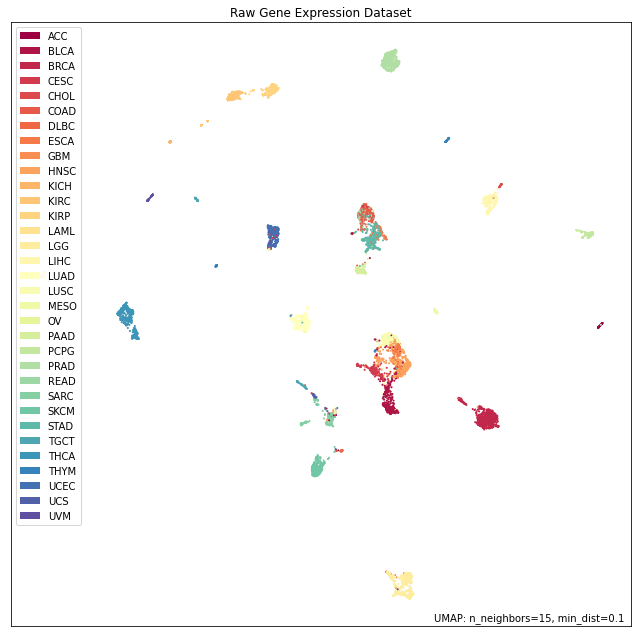

Showing UMAP


In [71]:
# Create UMAP Class
test = UMAPPlotter(ge, cancer_type_labels, "Raw Gene Expression Dataset", "/Users/bram/jointomicscomp/results/umaps/GE_test.png")

test.show()
